In [1]:
import advanced_simulator_h5
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi.inference import SNPE

output_dir = r"C:\Users\uhewm\Desktop\SBI_Data\simulation_chunks"

simulations = advanced_simulator_h5.load_simulation_results_h5(output_dir)

In [2]:
import clustering
import simulator
import torch
import re
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering

num_samples = len(gene_presence_absence_matrices[0][0])

gene_presence_absence_matrices_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in gene_presence_absence_matrices]

if all(isinstance(t, torch.Tensor) for t in gene_presence_absence_matrices_tensor):
    try:
        # Stack tensors along a new dimension
        gene_presence_absence_matrices_tensor = torch.stack(gene_presence_absence_matrices_tensor, dim=0)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        gene_presence_absence_matrices_tensor = torch.cat(gene_presence_absence_matrices_tensor, dim=0)

alleles_list_pca_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in alleles_list_pca_all_runs]

if all(isinstance(t, torch.Tensor) for t in alleles_list_pca_tensor):
    try:
        # Stack tensors along a new dimension
        alleles_list_pca_tensor = torch.stack(alleles_list_pca_tensor, dim=0)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        alleles_list_pca_tensor = torch.cat(alleles_list_pca_tensor, dim=0)

distance_matrices_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in distance_matrices]

if all(isinstance(t, torch.Tensor) for t in distance_matrices_tensor):
    try:
        # Stack tensors along a new dimension
        distance_matrices_tensor = torch.stack(distance_matrices_tensor, dim=0)
        distance_matrices_tensor = distance_matrices_tensor.unsqueeze(1)
    except RuntimeError:
        # If stack fails due to mismatched sizes, concatenate along the first dimension
        distance_matrices_tensor = torch.cat(distance_matrices_tensor, dim=0)
        distance_matrices_tensor = distance_matrices_tensor.unsqueeze(1)

gene_frequencies = gene_presence_absence_matrices_tensor.squeeze(1).sum(dim=1)/num_samples

hgt_rates_tensor = torch.tensor(hgt_rates)
hgt_rates_tensor = hgt_rates_tensor.view(-1, 1)  # Umformung zu einer Batch-Dimension

rhos_tensor = torch.tensor(rhos)
rhos_tensor = rhos_tensor.view(-1, 1)  # Umformung zu einer Batch-Dimension

fitch_scores_tensor = torch.tensor(fitch_scores_list)
fitch_scores_tensor = fitch_scores_tensor.view(-1, 1)

gene_number_hgt_events_passed_tensor = torch.tensor(gene_number_hgt_events_passed_list)
gene_number_hgt_events_passed_tensor = gene_number_hgt_events_passed_tensor.view(-1, 1) 

theta_tensor = torch.cat([hgt_rates_tensor, rhos_tensor, gene_number_hgt_events_passed_tensor], dim=1)

print("HGT_rates size: ", hgt_rates_tensor.size())
print("Rhos: ", rhos_tensor.size())
print("gene_number_hgt_events_passed_tensor: ", gene_number_hgt_events_passed_tensor.size())
print("theta_tensor: ", theta_tensor.size())

print("Fitch size: ", fitch_scores_tensor.size())
print("gene_presence_absence_matrices_tensor size: ", gene_presence_absence_matrices_tensor.size())
print("alleles_list_pca_tensor: ", alleles_list_pca_tensor.size())
print("distance_matrices_tensor: ", distance_matrices_tensor.size())

NameError: name 'gene_presence_absence_matrices' is not defined

In [ ]:
# Funktion: Flatten und concat Beobachtungen zu 2D Tensor [B, FeatureDim]
def flatten_and_concat(gene_tensor, allele_tensor, distances_tensor, fitch_tensor):
    B = gene_tensor.shape[0]
    gene_flat = gene_tensor.view(B, -1)             # [B, 1000]
    allele_flat = allele_tensor.view(B, -1)         # [B, 1*10*1000=10000]
    distances_flat = distances_tensor.view(B, -1)         # [B, 1*10*1000=10000]
    fitch_flat = fitch_tensor.view(B, -1)           # [B, 1]
    combined = torch.cat([gene_flat, allele_flat, distances_flat, fitch_flat], dim=1)  # [B, 11001]
    return combined

# Kombinierte Beobachtung
sim_data_tensor = flatten_and_concat(
    gene_presence_absence_matrices_tensor,
    alleles_list_pca_tensor,
    distance_matrices_tensor,
    fitch_scores_tensor
)

def unflatten_and_split(x: torch.Tensor, num_samples: int) -> tuple:
    """
    Zerlegt einen flach kombinierten Tensor wieder in seine Einzelbestandteile:
    - gene presence/absence matrix
    - allele PCA matrix
    - distance matrix
    - fitch score

    Args:
        x: Tensor der Form (B, N), der alle Komponenten enthält.
        alleles_shape: Tuple (A0, A1) — Form der Allele und Distance-Matrix.

    Returns:
        Tuple aus:
        - gene_tensor: (B, 1, A1)
        - allele_tensor: (B, 1, A0, A1)
        - distance_tensor: (B, 1, A0, A1)
        - fitch_tensor: (B, 1)
    """
    B = x.shape[0]
    A0, A1 = (num_samples, num_samples)
    G = A1  # Gene count entspricht A1
    D0, D1 = A0, A1

    # Längen der flachen Teile
    gene_len = G
    allele_len = A0 * A1
    distance_len = D0 * D1
    fitch_len = 1  # scalar

    # Slicing-Offsets
    gene_flat = x[:, :gene_len].view(B, 1, G)

    allele_start = gene_len
    allele_end = allele_start + allele_len
    allele_flat = x[:, allele_start:allele_end].view(B, 1, A0, A1)

    distance_start = allele_end
    distance_end = distance_start + distance_len
    distance_flat = x[:, distance_start:distance_end].view(B, 1, D0, D1)

    fitch_flat = x[:, distance_end:].view(B, 1)

    return gene_flat, allele_flat, distance_flat, fitch_flat


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.num_samples = num_samples

        self.Softplus = nn.Softplus()

        self.conv1d = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=0)
        conv1d_out_dim = self.conv1d(gene_presence_absence_matrices_tensor[0]).view(1, -1).shape[1]

        self.pointwise_combine_allele_distance = nn.Conv2d(in_channels=2*3, out_channels=8, kernel_size=1)
        
        dummy_input = torch.zeros(1, 1, num_samples, num_samples)
        out = self.min_max_avg_conv2d(dummy_input)
        out_combined = torch.cat([out, out], dim=1)
        conv2d_out_dim = self.pointwise_combine_allele_distance(out_combined).view(1, -1).shape[1]

        total_input_dim = conv1d_out_dim + conv2d_out_dim + 1 

        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, theta_tensor.size()[1]),
            nn.Softplus()
        )
        
    def min_max_avg_conv2d(self, x, kernel_size=5, stride=3, padding=0):
        """
        x: Tensor mit Shape [B, C, H, W]
        Kernel: z.B. 3x3
        Output: Tensor mit Shape [B, C*3, H_out, W_out], wobei für jeden Kanal
                Minimum, Maximum, Average über das jeweilige Fenster berechnet werden.
        """
    
        B, C, H, W = x.shape
    
        # 1. Unfold: extrahiere alle Fenster als Spalten
        # Ergebnis: [B, C * kernel_size*kernel_size, L], L = Anzahl Fenster = H_out * W_out
        x_unfold = F.unfold(x, kernel_size=kernel_size, stride=stride, padding=padding)
        # Shape: [B, C * k*k, L]
    
        k = kernel_size * kernel_size
        L = x_unfold.shape[-1]
    
        # 2. reshape zu [B, C, k*k, L]
        x_unfold = x_unfold.view(B, C, k, L)
    
        # 3. min, max, avg entlang Dimension k (Fenstergröße)
        min_vals = x_unfold.min(dim=2)[0]   # [B, C, L]
        max_vals = x_unfold.max(dim=2)[0]   # [B, C, L]
        avg_vals = x_unfold.mean(dim=2)     # [B, C, L]
    
        # 4. Concatenate diese 3 Werte pro Kanal
        out = torch.cat([min_vals, max_vals, avg_vals], dim=1)  # [B, C*3, L]
    
        # 5. Fold zurück zu Bild: Größe (H_out, W_out)
        H_out = (H + 2*padding - kernel_size)//stride + 1
        W_out = (W + 2*padding - kernel_size)//stride + 1
    
        out = out.view(B, C*3, H_out, W_out)
        return self.Softplus(out)
        
    def forward(self, x):
        """
        x: shape [B, total_features]
        """
        gene_flat, allele_flat, distance_flat, fitch_flat = unflatten_and_split(x, self.num_samples)

        gene_flat_conv_out = self.conv1d(gene_flat)
        allele_flat_conv_out = self.min_max_avg_conv2d(allele_flat)
        distance_flat_conv_out = self.min_max_avg_conv2d(distance_flat)

        allele_distance_combined = torch.cat([allele_flat_conv_out, distance_flat_conv_out], dim=1)
        
        allele_distance_combined_conv_out = self.pointwise_combine_allele_distance(allele_distance_combined)
        
        # --- Kombination

        parts = [gene_flat_conv_out, allele_distance_combined_conv_out, fitch_flat]

        parts = [p.view(p.size(0), -1) for p in parts]
        
        x = torch.cat(parts, dim=-1)
        
        return self.fc(x)


input_dim = sim_data_tensor.shape[1]
embedding_net = NeuralNetwork()

# Posterior NN von sbi
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=64, num_transforms=4
)

# Prior: Anpassen auf deine Parameterbereiche
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0, 0.0]),
    high=torch.tensor([torch.max(theta_tensor[:,0]), torch.max(theta_tensor[:,1]), torch.max(theta_tensor[:,2])])
)

# Inferenz mit SNPE
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# Daten an sbi übergeben
density_estimator = inference.append_simulations(theta_tensor, sim_data_tensor).train()

# Posterior bauen
posterior = inference.build_posterior(density_estimator)

print("Training abgeschlossen, Posterior ist bereit.")

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Listen zur Speicherung der Ergebnisse
true_values = []
predicted_means_hgt_rate = []
predicted_means_rho = []
predicted_means_gene_number_hgt_events_passed = []
absolute_differences_hgt_rate = []
absolute_differences_rho = []
absolute_differences_gene_number_hgt_events_passed = []

# Für alle Datenpunkte berechnen
indices = random.sample(range(len(hgt_rates)), k=min(5000, len(hgt_rates)))

for i in indices:
    x_test = sim_data_tensor[i]
    hgt_rate_test = hgt_rates[i]
    rho_rate_plot = rhos[i]
    gene_number_hgt_events_passed_plot = gene_number_hgt_events_passed_list[i][0]
    
    # Posterior-Samples generieren
    samples = posterior.sample((20,), x=torch.tensor(x_test))
    
    # Mittelwert der Samples berechnen
    mean_hgt_rate = samples[:, 0].mean().item()
    mean_rho = samples[:, 1].mean().item()
    mean_gene_number_hgt_events_passed = samples[:, 2].mean().item()
    
    # Speichern der Ergebnisse
    true_values.append(hgt_rate_test)
    predicted_means_hgt_rate.append(mean_hgt_rate)
    predicted_means_rho.append(mean_rho)
    predicted_means_gene_number_hgt_events_passed.append(mean_gene_number_hgt_events_passed)
    absolute_differences_hgt_rate.append(abs(hgt_rate_test - mean_hgt_rate))
    absolute_differences_rho.append(abs(rho_rate_plot - mean_rho))
    absolute_differences_gene_number_hgt_events_passed.append(abs(gene_number_hgt_events_passed_plot - mean_gene_number_hgt_events_passed))

In [ ]:
import matplotlib.pyplot as plt

# Hole Farbwerte für die geplotteten Punkte
colors = gene_frequencies[indices]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 Zeile, 3 Spalten

# === Plot 1: hgt_rate ===
sc0 = axs[0].scatter(
    hgt_rates_tensor[indices],
    predicted_means_hgt_rate,
    c=colors,
    cmap='RdYlGn',
    alpha=0.7,
    s=2
)
axs[0].plot(
    [min(hgt_rates_tensor), max(hgt_rates_tensor)],
    [min(hgt_rates_tensor), max(hgt_rates_tensor)],
    color="red", linestyle="--"
)
axs[0].set_xlabel("Real hgt_rate")
axs[0].set_ylabel("Predicted hgt_rate")
axs[0].set_title("Predicted vs Real hgt_rate")
cbar0 = fig.colorbar(sc0, ax=axs[0], orientation='vertical', pad=0.01)
cbar0.set_label("Gene frequency", fontsize=9)

# === Plot 2: rho ===
sc1 = axs[1].scatter(
    rhos_tensor[indices],
    predicted_means_rho,
    c=colors,
    cmap='RdYlGn',
    alpha=0.7,
    s=2
)
axs[1].plot(
    [min(rhos_tensor), max(rhos_tensor)],
    [min(rhos_tensor), max(rhos_tensor)],
    color="red", linestyle="--"
)
axs[1].set_xlabel("Real rho")
axs[1].set_ylabel("Predicted rho")
axs[1].set_title("Predicted vs Real rho")
cbar1 = fig.colorbar(sc1, ax=axs[1], orientation='vertical', pad=0.01)
cbar1.set_label("Gene frequency", fontsize=9)

# === Plot 3: number_of_hgt_events ===
sc2 = axs[2].scatter(
    gene_number_hgt_events_passed_tensor[indices],
    predicted_means_gene_number_hgt_events_passed,
    c=colors,
    cmap='RdYlGn',
    alpha=0.7,
    s=2
)
axs[2].plot(
    [min(gene_number_hgt_events_passed_list), max(gene_number_hgt_events_passed_list)],
    [min(gene_number_hgt_events_passed_list), max(gene_number_hgt_events_passed_list)],
    color="red", linestyle="--"
)
axs[2].set_xlabel("Real number_of_hgt events")
axs[2].set_ylabel("Predicted number_of_hgt events")
axs[2].set_title("Predicted vs Real number_of_hgt events")
cbar2 = fig.colorbar(sc2, ax=axs[2], orientation='vertical', pad=0.01)
cbar2.set_label("Gene frequency", fontsize=9)

# === Layout und Speichern ===
plt.tight_layout()
plt.savefig("combined_prediction_plots.png", dpi=300)
plt.show()


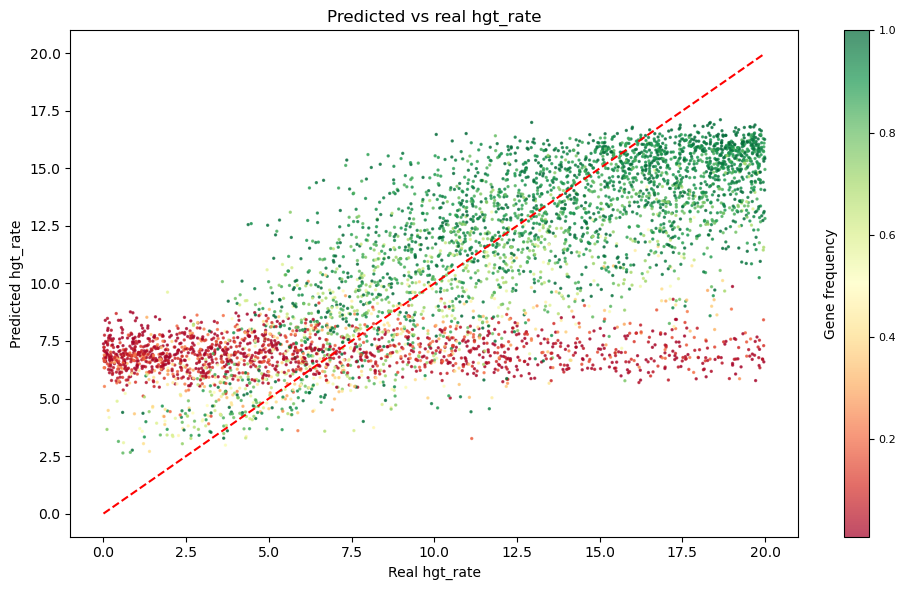

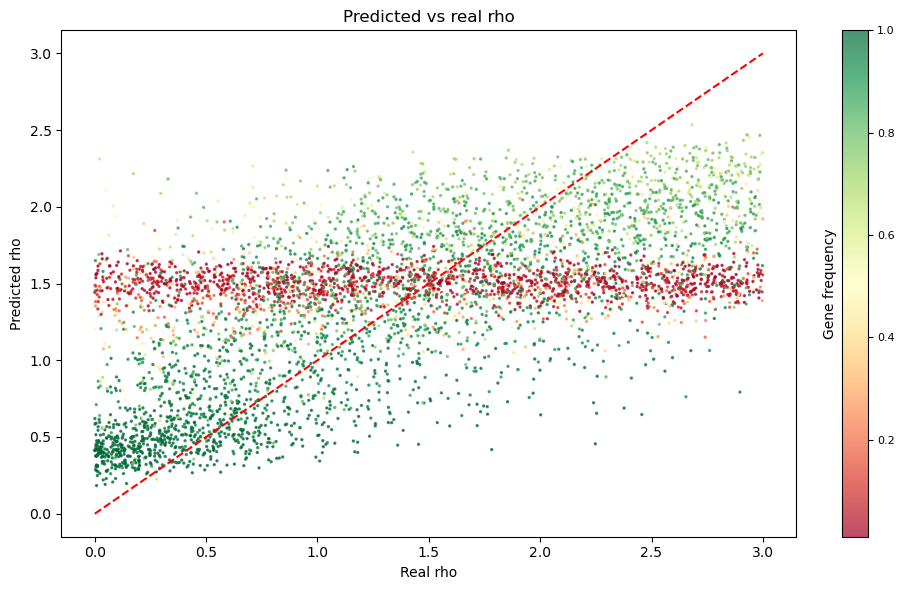

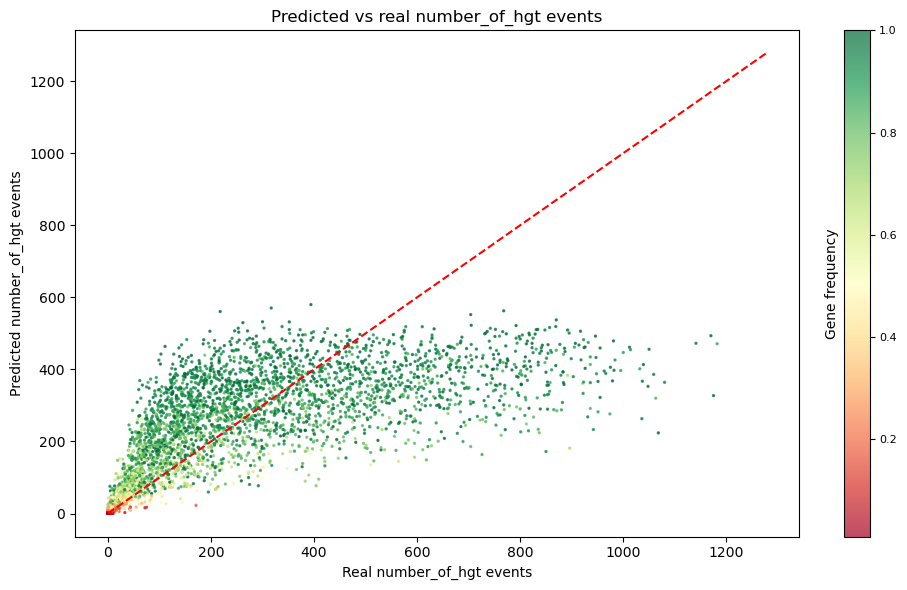

In [32]:
# Hole Farbwerte für die geplotteten Punkte
colors = gene_frequencies[indices]

plt.figure(figsize=(10, 6))

# Scatter-Plot mit Farbskala von rot nach grün
sc = plt.scatter(
    hgt_rates_tensor[indices],
    predicted_means_hgt_rate,
    c=colors,
    cmap='RdYlGn',      # Rot → Gelb → Grün
    alpha=0.7,
    s=2
)

# Diagonale
plt.plot(
    [min(hgt_rates_tensor), max(hgt_rates_tensor)],
    [min(hgt_rates_tensor), max(hgt_rates_tensor)],
    color="red", linestyle="--"
)

plt.xlabel("Real hgt_rate")
plt.ylabel("Predicted hgt_rate")
plt.title("Predicted vs real hgt_rate")

# Farbleiste als Legende oben rechts
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05)
cbar.set_label("Gene frequency", fontsize=10)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

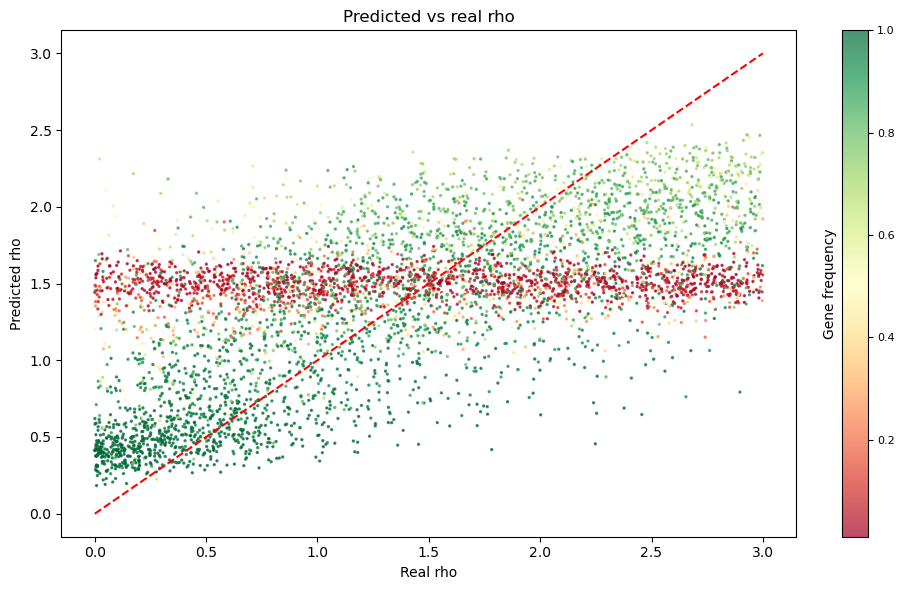

In [29]:
# Hole Farbwerte für die geplotteten Punkte
colors = gene_frequencies[indices]

plt.figure(figsize=(10, 6))

# Scatter-Plot mit Farbskala von rot nach grün
sc = plt.scatter(
    rhos_tensor[indices],
    predicted_means_rho,
    c=colors,
    cmap='RdYlGn',      # Rot → Gelb → Grün
    alpha=0.7,
    s=2
)

# Diagonale
plt.plot(
    [min(rhos_tensor), max(rhos_tensor)],
    [min(rhos_tensor), max(rhos_tensor)],
    color="red", linestyle="--"
)

plt.xlabel("Real rho")
plt.ylabel("Predicted rho")
plt.title("Predicted vs real rho")

# Farbleiste als Legende oben rechts
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05)
cbar.set_label("Gene frequency", fontsize=10)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()



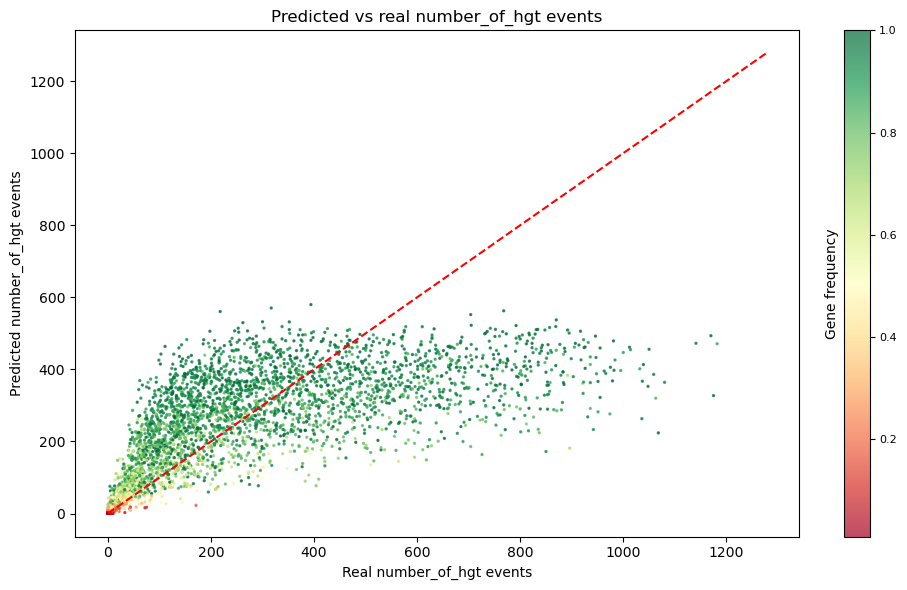

In [23]:
# Hole Farbwerte für die geplotteten Punkte
colors = gene_frequencies[indices]

plt.figure(figsize=(10, 6))

# Scatter-Plot mit Farbskala von rot nach grün
sc = plt.scatter(
    gene_number_hgt_events_passed_tensor[indices],
    predicted_means_gene_number_hgt_events_passed,
    c=colors,
    cmap='RdYlGn',      # Rot → Gelb → Grün
    alpha=0.7,
    s=2
)

# Diagonale
plt.plot(
    [min(gene_number_hgt_events_passed_list), max(gene_number_hgt_events_passed_list)],
    [min(gene_number_hgt_events_passed_list), max(gene_number_hgt_events_passed_list)],
    color="red", linestyle="--"
)

plt.xlabel("Real number_of_hgt events")
plt.ylabel("Predicted number_of_hgt events")
plt.title("Predicted vs real number_of_hgt events")

# Farbleiste als Legende oben rechts
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05)
cbar.set_label("Gene frequency", fontsize=10)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
